In [3]:
# Imports
import scipy
from scipy.signal import windows
from scipy.fft import fft
import numpy as np
import math
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import scipy.stats as stats
import statsmodels.api as sm

In [4]:
window_size_options = [0.1, 0.2, 0.5, 1] #seconds
generated_data = []

In [5]:

# Generating data, which is a list of spectrums for each window size.

sampling_rate = 1000  # Hz
aperiodic_exponent = 2.0
aperiodic_offset = 2.0
knee = 200
peaks = [{'freq': 12, 'amplitude': 1, 'sigma': 2}]

for i, window in enumerate(window_size_options):
    generated_data.append(spectrum(
        sampling_rate=sampling_rate,
        duration=window,
        aperiodic_exponent=aperiodic_exponent,
        aperiodic_offset=aperiodic_offset,
        knee=knee,
        peaks=peaks,
        average_firing_rate=0,
        random_state=42,
        direct_estimate=True,  # skip empirical PSD
        plot=False
    ))

In [6]:
"""
This function plots and returns the single taper spectral estimates for the given spectrum, assuming no Welch's method.
Args:
    spectrum (spectrum): The spectrum object containing time domain (combined broadband and rhythmic) data.
    taper_options (list): List of taper options to apply (strings).
    sampling_rate (float): The sampling rate of the signal.
Returns: 
    tuple: List of positive frequencies and the corresponding FFT results. Number of elements in the list is equal to the number of taper options.
"""
def plot_single_taper(spectrum, taper_options, sampling_rate): 
    N = len(spectrum.time_domain.combined_signal)
    fft_result = [0 for i in range(len(taper_options))] 
    for i, taper in enumerate(taper_options):
        tapered_signal = spectrum.time_domain.combined_signal * windows.get_window(taper, N)
        freqs = np.fft.fftfreq(N, d=1/sampling_rate)[1:N//2] # starting from 1 to avoid a divide by 0 error later.
        fft_result[i] = (fft(tapered_signal)[1:N//2] / freqs**2)
        plt.loglog(freqs, np.abs(fft_result[i]), label=taper, linewidth=1, alpha=0.5)
    return (freqs, fft_result)

"""
This function plots and returns the multitaper spectral estimates for the given spectrum, averaging the results across multiple DPSS tapers
and also providing the option for using just one DPSS taper. The latter may be useful for comparing directly with the single taper method.

Args:
    spectrum (spectrum): The spectrum object containing time domain (combined broadband and rhythmic) data.
    duration (float): The duration of the signal in seconds. We assume this is the window of the taper.
    sampling_rate (float): The sampling rate of the signal.
    isOneTaper (bool): If True, only one DPSS taper is used. If False, multiple DPSS tapers are used.
Returns: 
    tuple: Positive frequencies and the corresponding FFT results.
"""
def plot_multi_taper(spectrum, duration, sampling_rate, isOneTaper=False):
    N = len(spectrum.time_domain.time)
    t_w = N/2 - 1 if (duration*sampling_rate/2>=N/2) else duration*sampling_rate/2
    if isOneTaper:
        L = 1
    else:
        L = math.floor(t_w)-1
        print(L)
    tapered_signal = spectrum.time_domain.combined_signal * windows.dpss(N, t_w, L)
    sum = np.zeros(N//2 - 1)
    freqs = np.fft.fftfreq(N, d=1/sampling_rate)[1:N//2] # starting from 1 to avoid a divide by 0 error later.
    for dpss_taper in tapered_signal:
        fft_result = (fft(dpss_taper)[1:N//2])
        sum = (fft_result) + sum
    fft_result = sum / len(tapered_signal)
    plt.loglog(freqs, np.abs(fft_result), label='DPSS', linewidth=1, alpha=0.5)
    return (freqs, fft_result)


In [ ]:
from scipy.signal import welch

def welch_psd(signal, taper_options, fs=1000, duration=None, overlap=0):
    N = len(signal)
    nperseg = N if duration is None else int(duration * fs) # number of samples per segment
    noverlap = int(nperseg * overlap) # number of samples per overlap

    freqs, psd = welch(signal,
                       fs=fs,
                       window=taper_options,
                       nperseg=nperseg,
                       noverlap=noverlap,
                       scaling='density' # return psd
                       )

    return freqs, psd

/var/folders/qc/gskc2tx57z1gs3hq4hy86wfc0000gn/T/ipykernel_51740/2097369782.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


48
98
248
498


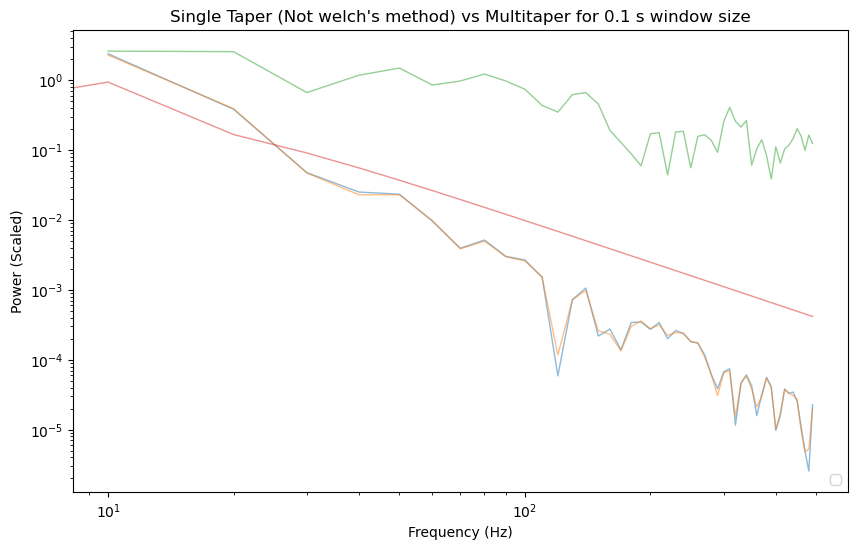

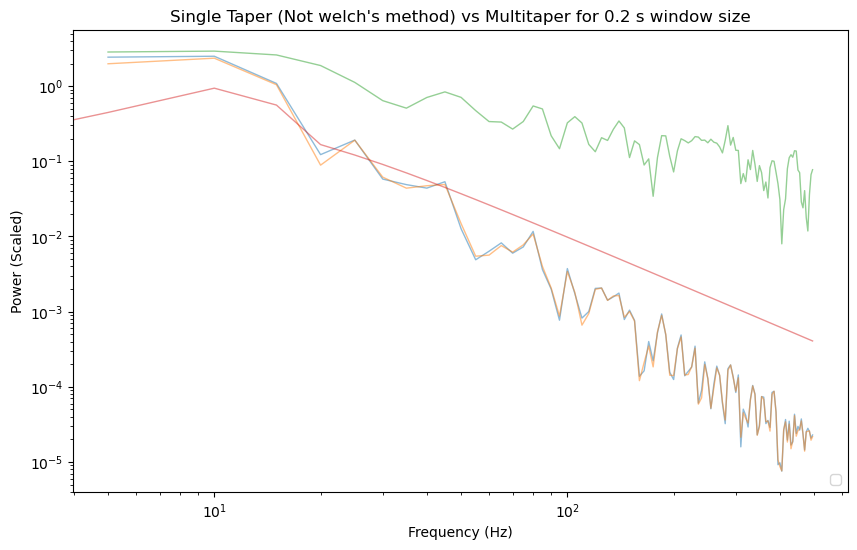

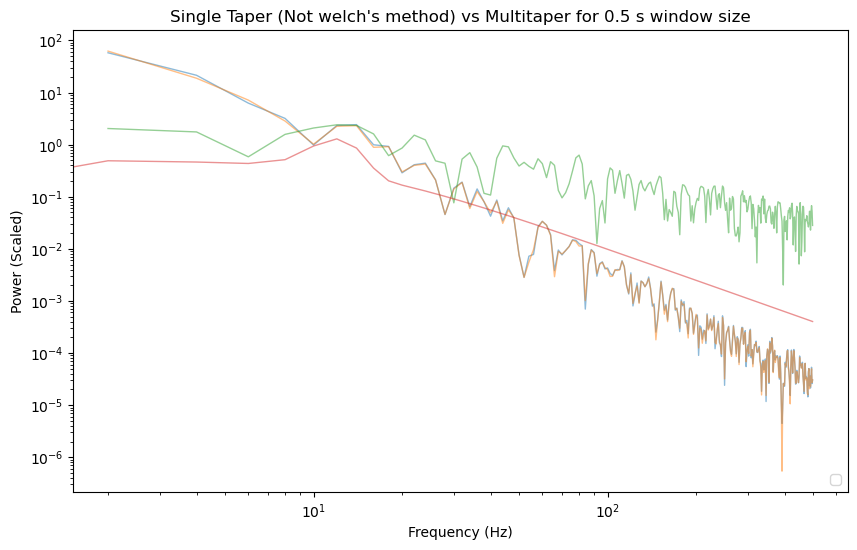

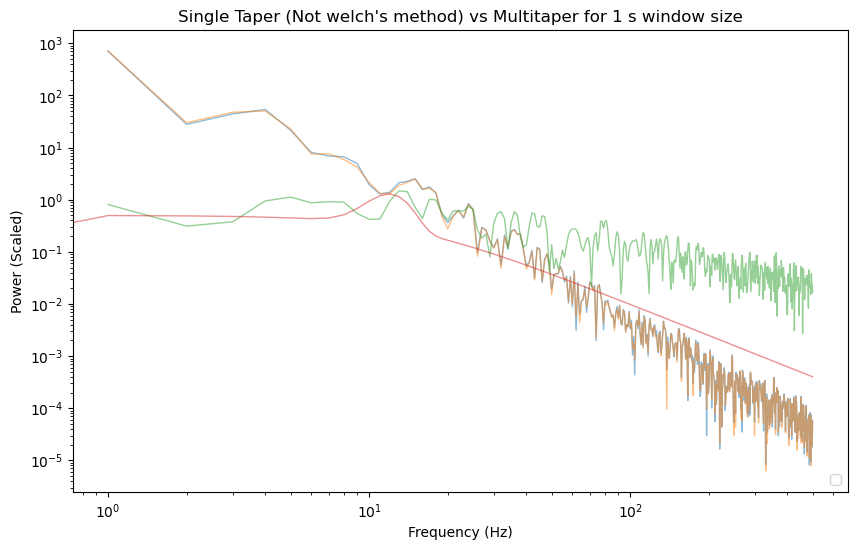

In [7]:
# Call the defined functions over all the generated data.

# Storing the FFT results for single taper and multitaper methods for each window size.

frqs_single, fft_result_single = [[] for i in range(len(window_size_options))], [[] for i in range(len(window_size_options))] 
# The single taper may have multiple tapers for each window size (based on what tapers the user chooses).
# For example, if the user chooses 'hamming' and 'hann', then the single taper will have two results for each window size.

frqs_multi, fft_result_multi = [0 for i in range(len(window_size_options))], [0 for i in range(len(window_size_options))]

for i, window in enumerate(window_size_options):
    # Plot setup
    plt.figure(figsize=(10, 6))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (Scaled)")
    plt.legend(loc="lower right")
    plt.title(f"Single Taper (Not welch's method) vs Multitaper for {window} s window size")

    # Store FFT results
    frqs_single[i], fft_result_single[i] = plot_single_taper(generated_data[i], taper_options=['hamming', 'hann'], sampling_rate=sampling_rate)
    frqs_multi, fft_result_multi = plot_multi_taper(generated_data[i], duration=window_size_options[i], sampling_rate=sampling_rate, isOneTaper=False)

    # Plot empirical PSD
    N = len(generated_data[i].time_domain.combined_signal)
    freqs = np.fft.fftfreq(N, d=1/sampling_rate)[0:N//2] # starting from 1 to avoid a divide by 0 error later.
    plt.loglog(freqs, generated_data[i].frequency_domain.combined_spectrum, linewidth=1, alpha=0.5, label='empirical')
    

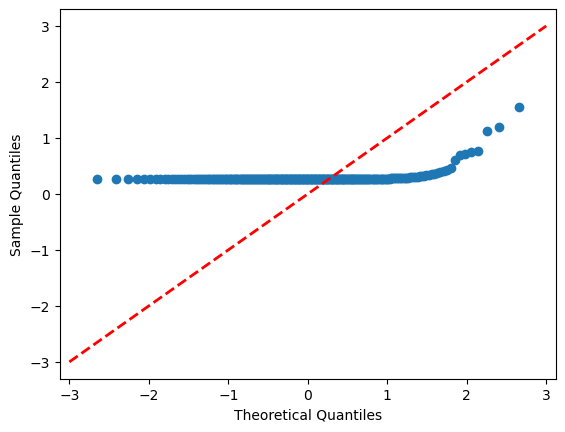

In [12]:
# just trying something, may not be appropriate to do a QQ plot in this context but I think they did it in the paper?
# not sure why it's so bad or if it's expected to be this bad.
residuals = generated_data[2].frequency_domain.combined_spectrum - fft_result_multi[2]
fig = sm.qqplot(residuals)
plt.plot(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), 'r--', lw=2)
plt.show()

(array([[2.03838405e-03, 5.50716452e-05, 1.07077317e-05, 3.35360946e-06,
         1.36535837e-06, 6.55898403e-07, 3.53093682e-07, 2.06576266e-07,
         1.28775583e-07, 8.43929053e-08, 5.75885484e-08, 4.06307668e-08,
         2.94804506e-08, 2.19060900e-08, 1.66155408e-08, 1.28300556e-08,
         1.00638285e-08, 8.00455214e-09, 6.44607788e-09],
        [1.74728679e-03, 2.93933711e-05, 5.68562125e-06, 1.77943605e-06,
         7.24344974e-07, 3.47948332e-07, 1.87310279e-07, 1.09584765e-07,
         6.83129460e-08, 4.47688309e-08, 3.05496655e-08, 2.15539014e-08,
         1.56388750e-08, 1.16208187e-08, 8.81427815e-09, 6.80614458e-09,
         5.33870811e-09, 4.24629601e-09, 3.41955047e-09],
        [6.75162268e-04, 3.21669986e-07, 2.86918124e-08, 5.21693173e-09,
         1.41052507e-09, 4.91139100e-10, 2.03843050e-10, 9.62612933e-11,
         5.01795425e-11, 2.82786992e-11, 1.69716346e-11, 1.07264664e-11,
         7.07842333e-12, 4.84453784e-12, 3.42047962e-12, 2.48066843e-12,
        

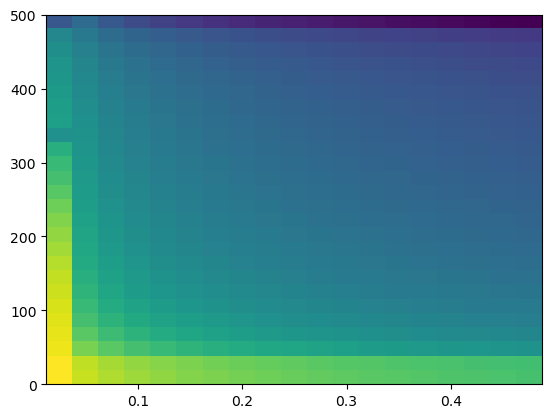

In [27]:
import matplotlib as mat
NFFT = len(generated_data[0].frequency_domain.combined_spectrum)
plt.specgram(
    generated_data[3].frequency_domain.combined_spectrum,
    Fs=sampling_rate,
    window=mat.mlab.window_hanning(np.ones(NFFT)),
    NFFT=NFFT,
    sides='onesided',
    noverlap=NFFT // 2, # I don't know why we're doing this?
    cmap='viridis'
)